In [1]:
import pandas as pd
from sqlalchemy import create_engine
import yaml
import psycopg2 as pg2
import numpy as np
import ohio.ext.pandas
import numpy as np

with open('secrets.yaml', 'r') as f:
    secrets = yaml.safe_load(f)

# Option 1 is 'engine' for sqlalchemy
db_params = secrets['db']
engine = create_engine('postgres://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['dbname'],
  user=db_params['user'],
  password=db_params['password']
))

# Option 2 is using psycopg2
with open('/data/users/dschnelb/secrets.yaml', 'r') as f:
    # loads contents of secrets.yaml into a python dictionary
    secret_config = yaml.safe_load(f.read())

db_params = secret_config['db']
conn = pg2.connect(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['dbname'],
  user=db_params['user'],
  password=db_params['password'])

# connect cursor for database retrieval
cur = conn.cursor()

## For reference: running beginning of code to get the data loaded as the program does

In [5]:
from functools import reduce
import os
from shutil import copyfile

import numpy as np
import pandas as pd

from configloader import load_config
from load_data import get_graduation_info, get_loader, connect_cursor
import metrics
from model import train_model
from util.visualization import plot_precision_at_10, plot_roc, plot_feature_importance
from util.interpretability import model_inter


class Experiment:
    def __init__(self, config_path, secret_path, model_save_dir,
                 result_save_dir):
        self.config_path = config_path
        self.secret_path = secret_path
        self.model_save_dir = model_save_dir
        self.result_save_dir = result_save_dir
        self.loaders, self.labeler, self.splitter, self.preprocessor, self.imputer, self.model = load_config(
            self.config_path)

    def run(self):
        """Run entire pipeline."""
        cur = connect_cursor(self.secret_path)

        # Get graduation info
        df = get_graduation_info(cur)
        grad_info_cols = df.columns

        df['student_lookup'] = df['student_lookup'].astype(int)
        df = df.set_index('student_lookup')
        assert df.index.is_unique
        loaded_df = reduce(lambda x, y: x.join(y, how='outer'), [
            get_loader(loader_key)(cur=cur, **
                                   loader_kwargs).set_index('student_lookup')
            for loader_key, loader_kwargs in self.loaders.items()
        ])
        assert loaded_df.index.is_unique
        df = df.join(loaded_df)
        assert df.index.is_unique

In [2]:
cur.execute('''
                select *
                from (
		               SELECT *, ROW_NUMBER() OVER
		                    (PARTITION BY student_lookup
                            ORDER BY student_lookup) AS rnum
		               FROM sketch.hs_withdraw_info_2 hwi) t
                where t.rnum = 1
                and t.entry_year >= 2007 and t.entry_year <= 2013
                ''')

# Use cursor to fetch all rows into a list
rows = cur.fetchall()

# Build dataframe from rows
df = pd.DataFrame(rows, columns=[name[0] for name in cur.description])

# Make sure student_id is an int
df['student_lookup'] = df['student_lookup'].astype('int')

In [6]:
grad_info_cols = df.columns

df['student_lookup'] = df['student_lookup'].astype(int)
df = df.set_index('student_lookup')
assert df.index.is_unique


In [89]:
## Set a config loader, local thing in case I want to manipulate anything

In [3]:
import os

In [4]:
os.chdir('./mlpolicylab_fall20_schools2/src')

In [8]:
loaders, labeler, splitter, preprocessor, imputer, model = load_config(
            '/data/users/dschnelb/rf_local_baseline.yaml')


In [9]:
loaded_df = reduce(lambda x, y: x.join(y, how='outer'), [
    get_loader(loader_key)(cur=cur, **
                            loader_kwargs).set_index('student_lookup')
    for loader_key, loader_kwargs in loaders.items()
])

In [10]:
len(loaded_df)

48912

In [11]:
df2 = df.join(loaded_df)
assert df2.index.is_unique

In [12]:
df2[:10]

,entry_year,grad_year,dropout_year,in_state_transfer_year,transfer_out_year,withdrew_year,grade_12_entry_year,grade_12_withdraw_reason,rnum,absent_grade_5_absence_excused,...,ogt_science_pl_Basic,ogt_science_pl_Limited,ogt_science_pl_Proficient,ogt_science_missing,ogt_socstudies_pl_Accelerated,ogt_socstudies_pl_Advanced,ogt_socstudies_pl_Basic,ogt_socstudies_pl_Limited,ogt_socstudies_pl_Proficient,ogt_socstudies_missing
student_lookup,,,,,,,,,,,,,,,,,,,,,
46,2012,NaN,2015.0,NaN,NaN,NaN,2015.0,did not withdraw,1,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47,2013,NaN,NaN,2015.0,NaN,NaN,2015.0,transferred - in state,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48,2012,NaN,NaN,NaN,NaN,NaN,NaN,None,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
50,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
269,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
286,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
297,2012,NaN,2015.0,NaN,NaN,NaN,2014.0,did not withdraw,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338,2013,NaN,NaN,NaN,NaN,NaN,2015.0,None,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
df3, labels = labeler.transform(df2)

In [14]:
df3[:10]

,entry_year,grad_year,dropout_year,in_state_transfer_year,transfer_out_year,withdrew_year,grade_12_entry_year,grade_12_withdraw_reason,rnum,absent_grade_5_absence_excused,...,ogt_science_pl_Basic,ogt_science_pl_Limited,ogt_science_pl_Proficient,ogt_science_missing,ogt_socstudies_pl_Accelerated,ogt_socstudies_pl_Advanced,ogt_socstudies_pl_Basic,ogt_socstudies_pl_Limited,ogt_socstudies_pl_Proficient,ogt_socstudies_missing
student_lookup,,,,,,,,,,,,,,,,,,,,,
46,2012,NaN,2015.0,NaN,NaN,NaN,2015.0,did not withdraw,1,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
48,2012,NaN,NaN,NaN,NaN,NaN,NaN,None,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
49,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
50,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
269,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
286,2013,2015.0,NaN,NaN,NaN,NaN,2015.0,graduate,1,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
297,2012,NaN,2015.0,NaN,NaN,NaN,2014.0,did not withdraw,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
338,2013,NaN,NaN,NaN,NaN,NaN,2015.0,None,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
407,2013,NaN,NaN,NaN,NaN,NaN,2015.0,None,1,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
splits = splitter.transform(df3, labels)

In [31]:
info_cols = [col for col in grad_info_cols if col != 'student_lookup']
for year, (train_df, _), (test_df, _) in splits:
    train_df.drop(info_cols, inplace=True, axis=1)
    test_df.drop(info_cols, inplace=True, axis=1)


In [22]:
preprocessed_splits = [(year, *(preprocessor.transform(
            (train_pair, test_pair))))
                               for year, train_pair, test_pair in splits]

In [64]:
preprocessed_splits[0];

In [23]:
def impute(split):
            year, (train_df, train_label), (test_df, test_label) = split
            assert train_df.index.equals(train_label.index)
            assert train_df.index.is_unique
            train_df, test_df = imputer.transform(train_df, test_df)

            assert train_df.index.equals(
                train_df.index.intersection(train_label.index))
            train_label, test_label = train_label.sort_index().loc[
                train_df.index.intersection(train_label.index), :].copy(
                ), test_label.loc[test_df.index, :].copy()
            assert train_df.index.is_unique
            assert train_label.index.is_unique
            assert train_df.index.equals(train_label.index)
            return year, (train_df, train_label), (test_df, test_label)


In [24]:
preprocessed_splits = [impute(split) for split in preprocessed_splits]

In [25]:
preprocessed_splits[0][2][0]

,absent_grade_5_absence_excused,absent_grade_5_absence_unexcused,absent_grade_5_tardy_unexcused,absent_grade_6_absence_excused,absent_grade_6_misc,absent_grade_7_absence_excused,absent_grade_7_tardy_unexcused,absent_grade_8_absence_excused,absent_grade_8_suspension_educated,absent_grade_8_tardy_unexcused,...,ogt_science_pl_Basic_imputed,ogt_science_pl_Limited_imputed,ogt_science_pl_Proficient_imputed,ogt_science_missing_imputed,ogt_socstudies_pl_Accelerated_imputed,ogt_socstudies_pl_Advanced_imputed,ogt_socstudies_pl_Basic_imputed,ogt_socstudies_pl_Limited_imputed,ogt_socstudies_pl_Proficient_imputed,ogt_socstudies_missing_imputed
student_lookup,,,,,,,,,,,,,,,,,,,,,
585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
7564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
14305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
16932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
34374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
54565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
54630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [33]:
# Can look at before and after 
split2010 = preprocessed_splits[0][2][0]
split_noimp = splits[0][2][0]

In [36]:
medians = split_noimp.median()

## Can use filter to look at medians before imputation

In [60]:
medians.filter(like="_pl_")

kral_pl_Enriched                 0.0
kral_pl_Intense                  0.0
kral_pl_Targeted                 0.0
third_read_pl_99                 0.0
third_read_pl_Accelerated        0.0
                                ... 
ogt_socstudies_pl_Accelerated    0.0
ogt_socstudies_pl_Advanced       0.0
ogt_socstudies_pl_Basic          0.0
ogt_socstudies_pl_Limited        0.0
ogt_socstudies_pl_Proficient     0.0
Length: 172, dtype: float64

In [93]:
split_noimp[['gpa_9']]

,gpa_9
student_lookup,
585,NaN
7564,3.7111111111111111
14305,NaN
16932,NaN
34374,2.2133333333333333
...,...
54461,NaN
54565,NaN
54630,NaN


In [95]:
split2010[['gpa_9']]

,gpa_9
student_lookup,
585,2.94
7564,3.7111111111111111
14305,2.94
16932,2.94
34374,2.2133333333333333
...,...
54461,2.94
54565,2.94
54630,2.94


# Zooming in on a split, we are imputing a 2.94 GPA, which is very high!

## Use below to filter df by entry year and see what medians would be

In [66]:
mdn_df = df3.groupby('entry_year').median().T

In [81]:
mdn_df.filter(like='_ss', axis=0)

entry_year,2007,2008,2009,2010,2011,2012,2013
third_read_ss,NaN,NaN,NaN,420.0,419.0,422.0,423.0
third_math_ss,NaN,NaN,NaN,NaN,422.0,429.0,431.0
fourth_read_ss,222.0,224.0,229.0,425.0,427.0,429.0,427.0
fourth_math_ss,224.0,227.0,230.0,234.0,432.0,425.0,427.0
fourth_write_ss,6.0,6.0,6.0,415.0,427.0,418.0,421.0
fourth_ctz_ss,227.0,228.0,223.0,235.0,210.0,208.0,256.0
fourth_science_ss,227.0,232.0,230.0,238.0,195.5,225.0,243.0
fifth_read_ss,425.0,396.5,422.0,429.0,427.5,421.0,423.0
fifth_math_ss,NaN,NaN,385.0,421.0,416.0,414.0,414.0
fifth_socstudies_ss,NaN,NaN,NaN,NaN,412.0,412.0,413.0


# General missingness

In [70]:
missing = df2.isna().sum()/len(df2)

In [71]:
missing

entry_year                      0.000000
grad_year                       0.305636
dropout_year                    0.974745
in_state_transfer_year          0.804272
transfer_out_year               0.975290
                                  ...   
ogt_socstudies_pl_Advanced      0.049809
ogt_socstudies_pl_Basic         0.049809
ogt_socstudies_pl_Limited       0.049809
ogt_socstudies_pl_Proficient    0.049809
ogt_socstudies_missing          0.049809
Length: 868, dtype: float64

In [72]:
missing.filter(like='gpa').sort_values()

gpa_9_missing          0.159327
school_gpa_9_rank      0.159327
gpa_9                  0.327851
school_gpa_9_decile    0.328475
dtype: float64

In [73]:
import matplotlib.pyplot as plt

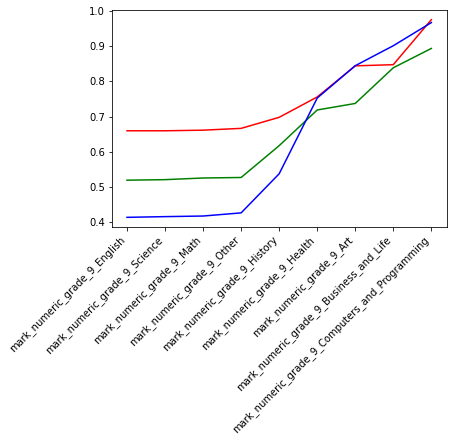

In [141]:
with pd.plotting.plot_params.use('x_compat', True):
    missing.filter(like='mark_numeric_grade_7').sort_values().plot(color='r')
    missing.filter(like='mark_numeric_grade_8').sort_values().plot(color='g')
    missing.filter(like='mark_numeric_grade_9').sort_values().plot(color='b')
    plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)

In [93]:
missing_by_year = []
for i in range(2007,2014):
    missing = df2[df2['entry_year']==i].isna().sum()/len(df2[df2['entry_year']==i])
    missing_by_year.append(missing)

In [94]:
missing = pd.DataFrame([missing_by_year[0],missing_by_year[1]
                ,missing_by_year[2],missing_by_year[3]
                ,missing_by_year[4] ,missing_by_year[5]
                 ,missing_by_year[6]])

missing['entry_year'] = [2007,2008,2009,2010,2011,2012,2013]
missing

,entry_year,grad_year,dropout_year,in_state_transfer_year,transfer_out_year,withdrew_year,grade_12_entry_year,grade_12_withdraw_reason,rnum,absent_grade_5_absence_excused,...,ogt_science_pl_Basic,ogt_science_pl_Limited,ogt_science_pl_Proficient,ogt_science_missing,ogt_socstudies_pl_Accelerated,ogt_socstudies_pl_Advanced,ogt_socstudies_pl_Basic,ogt_socstudies_pl_Limited,ogt_socstudies_pl_Proficient,ogt_socstudies_missing
0,2007,0.209690,0.979561,0.845572,0.981075,1.000000,0.140045,0.140045,0.0,0.998486,...,0.120363,0.120363,0.120363,0.120363,0.120363,0.120363,0.120363,0.120363,0.120363,0.120363
1,2008,0.202492,0.978193,0.767913,0.964174,0.999221,0.144081,0.145639,0.0,1.000000,...,0.023364,0.023364,0.023364,0.023364,0.023364,0.023364,0.023364,0.023364,0.023364,0.023364
2,2009,0.215845,0.973323,0.754244,0.966047,1.000000,0.145513,0.154406,0.0,0.994341,...,0.038804,0.038804,0.038804,0.038804,0.038804,0.038804,0.038804,0.038804,0.038804,0.038804
3,2010,0.188000,0.972667,0.762667,0.973333,0.998667,0.126000,0.130667,0.0,0.614000,...,0.020667,0.020667,0.020667,0.020667,0.020667,0.020667,0.020667,0.020667,0.020667,0.020667
4,2011,0.302978,0.976694,0.804489,0.979284,0.998705,0.153647,0.239102,0.0,0.744929,...,0.035822,0.035822,0.035822,0.035822,0.035822,0.035822,0.035822,0.035822,0.035822,0.035822
5,2012,0.299179,0.960892,0.814627,0.976144,0.999609,0.158389,0.243254,0.0,0.667188,...,0.030896,0.030896,0.030896,0.030896,0.030896,0.030896,0.030896,0.030896,0.030896,0.030896
6,2013,0.523536,0.984309,0.838500,0.978951,0.999235,0.179487,0.368925,0.0,0.671259,...,0.079985,0.079985,0.079985,0.079985,0.079985,0.079985,0.079985,0.079985,0.079985,0.079985


In [95]:
missing_by_year = missing.set_index('entry_year').T

In [97]:
missing_by_year.filter(like='gpa', axis=0)

entry_year,2007,2008,2009,2010,2011,2012,2013
gpa_9,0.249054,0.134735,0.167340,0.301333,0.511437,0.517012,0.205894
gpa_9_missing,0.143073,0.047508,0.062247,0.210667,0.437635,0.104028,0.046307
school_gpa_9_rank,0.143073,0.047508,0.062247,0.210667,0.437635,0.104028,0.046307
school_gpa_9_decile,0.249054,0.135514,0.167340,0.302000,0.511869,0.517403,0.207424


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, 'ogt_socstudies_pl_Advanced'),
  Text(0.0, 0, 'ogt_read_ss'),
  Text(5.0, 0, 'ogt_read_pl_99'),
  Text(10.0, 0, 'ogt_read_pl_Proficient'),
  Text(15.0, 0, 'ogt_math_pl_Basic'),
  Text(20.0, 0, 'ogt_write_pl_Accelerated'),
  Text(25.0, 0, 'ogt_write_missing'),
  Text(30.0, 0, 'ogt_science_pl_Limited'),
  Text(35.0, 0, 'ogt_socstudies_pl_Basic'),
  Text(40.0, 0, '')])

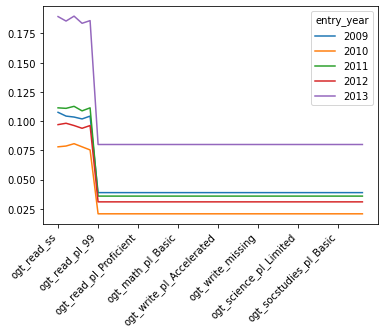

In [173]:
missing_by_year.filter(like='ogt', axis=0).plot()
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)

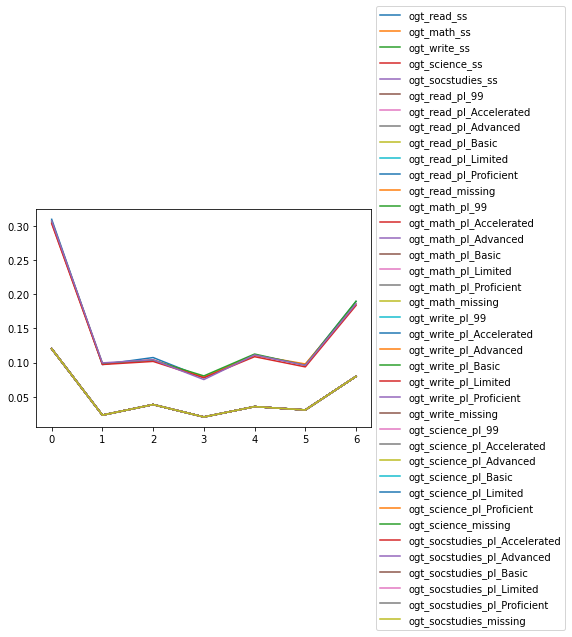

In [98]:
missing.filter(regex='ogt', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

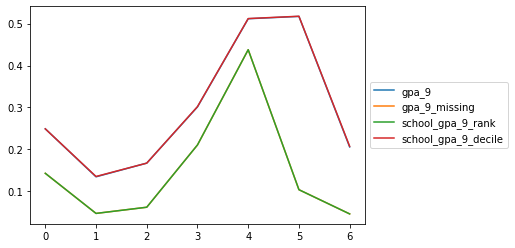

In [99]:
missing.filter(regex='gpa', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

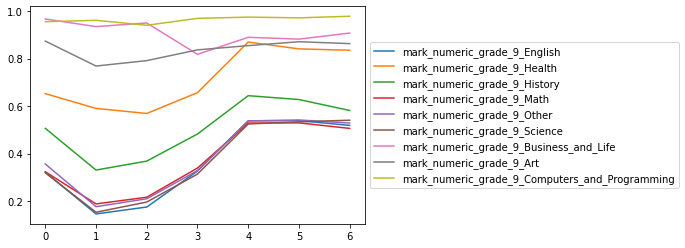

In [100]:
missing.filter(regex='mark_numeric_grade_9', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

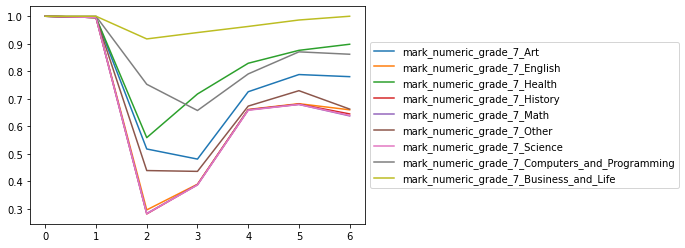

In [101]:
missing.filter(regex='mark_numeric_grade_7', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

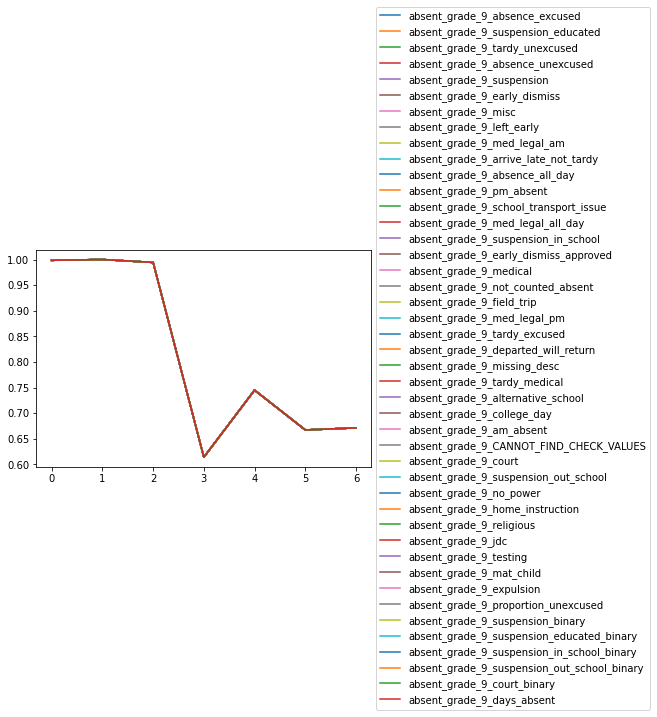

In [102]:
missing.filter(regex='absent_grade_9', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [30]:
qry = ''' select * from sketch.absences; '''

cur.execute(qry)

rows = cur.fetchall()

abs = pd.DataFrame([[int(row[0])] + list(row)[1:] for row in rows],
                    columns=[name[0] for name in cur.description])

abs = abs.replace(np.nan, 0)

# Make sure student_id is an int
abs['student_lookup'] = abs['student_lookup'].astype('int')

In [20]:
abs

,student_lookup,absent_grade_5_absence_excused,absent_grade_5_absence_unexcused,absent_grade_5_tardy_unexcused,absent_grade_6_absence_excused,absent_grade_6_misc,absent_grade_7_absence_excused,absent_grade_7_tardy_unexcused,absent_grade_8_absence_excused,absent_grade_8_suspension_educated,...,absent_grade_5_court_binary,absent_grade_6_court_binary,absent_grade_7_court_binary,absent_grade_8_court_binary,absent_grade_9_court_binary,absent_grade_5_days_absent,absent_grade_6_days_absent,absent_grade_7_days_absent,absent_grade_8_days_absent,absent_grade_9_days_absent
0,20,2.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,3.5,0.0,0.0,0.0,0.0
1,47,0.0,0.0,0.0,13.5,0.0,9.5,0.0,17.0,3.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,48,0.0,0.0,0.0,0.0,0.0,6.5,0.0,8.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,9.0,9.0
3,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,51,18.0,0.0,0.0,20.5,0.0,24.0,0.0,29.0,0.0,...,0,0,0,0,0,0.0,0.0,28.0,30.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18563,700274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
18564,700284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
18565,700288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
18566,700314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [23]:
abs2 = df.join(abs)

In [26]:
df.index

Int64Index([    46,     47,     48,     49,     50,    269,    286,    297,
               338,    407,
            ...
            701128, 701129, 701134, 701138, 701159, 701167, 701170, 701177,
            701180, 701182],
           dtype='int64', name='student_lookup', length=12829)

In [31]:
dfset = set(df.index)
absset = set(abs.index)

In [29]:
len(dfset)
# absset 18568

12829

In [34]:
len(dfset.intersection(absset))

2302

In [ ]:
# Very few students end up having logged features in "absences" to attach to the grade 10 entrants. Presumably they just didn't miss days. But missingness is high in a lot of places, it seems. That is, the "feature tables" I made for all student_lookups in grades preceding grade 10 do not seem to cover the universe of students entering grade 10 in many cases. 